In [10]:
import matplotlib.pyplot as plt
from sklearn.feature_selection import mutual_info_regression
import pymc3 as pm
import numpy as np
from GPyOpt.methods import BayesianOptimization
import arviz as az
import theano
import theano.tensor as tt
from scipy.stats import bernoulli
from scipy import stats
import opendp.smartnoise.core as sn
import pandas as pd
from scipy import optimize as opt

In [14]:
real = lambda s1,s2,s3,s4: 0.5*np.log(1+((s1**2)/(s2**2+s3**2+s4**2)))
wrapper = lambda w: -real(w[0],w[1],w[2],w[3])
res = opt.fmin(wrapper, [0.1,0.1,0.1,0.1], maxiter=10_000)

In [17]:
res[0]

0.31593521005532277

In [18]:
def f(A,O):
    return (A+O)/2


with pm.Model() as model:
    A = pm.Uniform("A", 0, 100)
    theta_1 = pm.Uniform("theta1", 0, 100)
    theta_2 = pm.Uniform("theta2", 0.0001, 10_000)
    O = pm.Normal("O", theta_1, theta_2)
    
    out = pm.Deterministic("out", f(A,O))
    
    trace = pm.sample(10_000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [O, theta2, theta1, A]


Sampling 2 chains for 1_000 tune and 10_000 draw iterations (2_000 + 20_000 draws total) took 16 seconds.
There were 1684 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6822978363672191, but should be close to 0.8. Try to increase the number of tuning steps.
There were 1279 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'O'}>,
        <AxesSubplot:title={'center':'A'}>,
        <AxesSubplot:title={'center':'theta1'}>],
       [<AxesSubplot:title={'center':'theta2'}>,
        <AxesSubplot:title={'center':'out'}>, <AxesSubplot:>]],
      dtype=object)

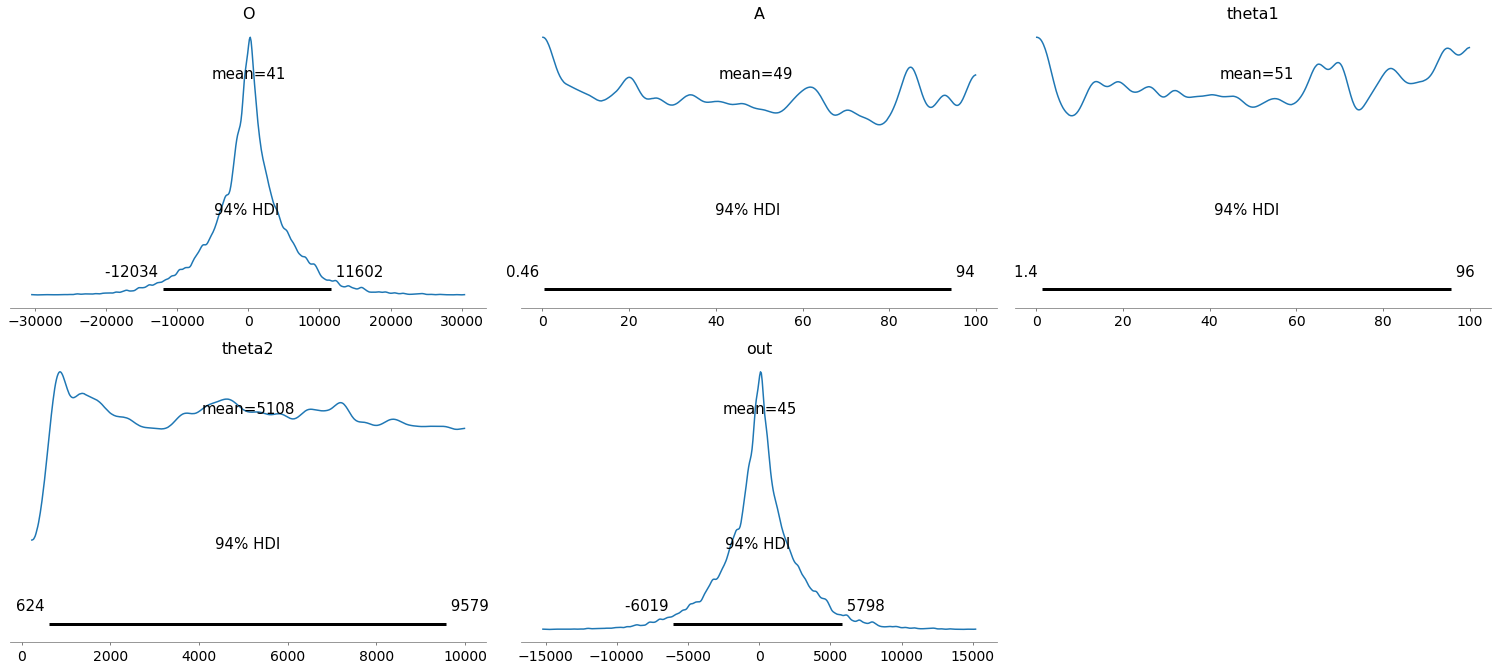

In [19]:
az.plot_posterior(trace)

In [32]:
import logging
@theano.compile.ops.as_op(itypes=[tt.dscalar, tt.dscalar],
                          otypes=[tt.dscalar])
def test(mu, sigma):
    i = np.random.randint(0,100_000_000)
    logger = logging.getLogger('pymc3')
    logger.disable=True
    logger.setLevel(logging.ERROR)
    logger.propagate = False
    with pm.Model() as model:
        A = pm.Uniform(f"A{i}", 0, 100)
        O = pm.Normal(f"O{i}", mu, sigma)

        out = pm.Deterministic(f"out{i}", f(A,O))

        trace = pm.sample(1000, progressbar=0)
        logger.disable=False
        return mutual_info_regression(trace[f"A{i}"].reshape(-1,1), trace[f"out{i}"])[0]

with pm.Model() as model2:
    theta_1 = pm.Uniform("t1", 0, 100)
    theta_2 = pm.Uniform("t2", 0.001, 1_000)
    
    output = pm.Deterministic("output", test(theta_1,theta_2))
    
    trace = pm.sample(1000)

FileNotFoundError: [Errno 2] No such file or directory: '/home/maoj/.theano/compiledir_Linux-4.4--Microsoft-x86_64-with-glibc2.29-x86_64-3.8.5-64/tmpi67a__mg/key.pkl'
Apply node that caused the error: FromFunctionOp{test}(t1, t2)
Toposort index: 8
Inputs types: [TensorType(float64, scalar), TensorType(float64, scalar)]
Inputs shapes: [(), ()]
Inputs strides: [(), ()]
Inputs values: [array(71.34013276), array(523.95175852)]
Outputs clients: [['output']]

Backtrace when the node is created(use Theano flag traceback__limit=N to make it longer):
  File "/home/maoj/.local/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 539, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/maoj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2886, in run_cell
    result = self._run_cell(
  File "/home/maoj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2932, in _run_cell
    return runner(coro)
  File "/home/maoj/.local/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/maoj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3155, in run_cell_async
    has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
  File "/home/maoj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3347, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/maoj/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3427, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-429a9a758dad>", line 24, in <module>
    output = pm.Deterministic("output", test(theta_1,theta_2))

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.